In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch as th
import torch.nn as nn
import dgl
from dgl import function as fn
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from dgl import DGLGraph
import torch.nn.functional as F
from torch.autograd import Variable
import time
import seaborn
from geopy.distance import geodesic

Using backend: pytorch


## 实验准备

In [3]:
class TAGConv(nn.Module):
    def __init__(self,
                 in_feats,    
                 out_feats,   
                 k=2,         
                 bias=True,   
                 activation=None): 
        super(TAGConv, self).__init__()   
        self._in_feats = in_feats  
        self._out_feats = out_feats 
        self._k = k
        self._activation = activation
        self.lin = nn.Linear(in_feats * (self._k + 1), out_feats, bias=bias) 

        self.reset_parameters() 


    def reset_parameters(self):      
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')     
        nn.init.xavier_normal_(self.lin.weight, gain=gain)   

        
    def forward(self, graph, feat):    
        graph = graph.local_var()           
        
        norm = th.pow(graph.in_degrees().float().clamp(min=1), -0.5) 
    
        
        shp = norm.shape + (1,) * (feat.dim() - 1)    
        
        norm = th.reshape(norm, shp).to(feat.device)  

        #D-1/2 A D -1/2 X
        fstack = [feat]      
        for _ in range(self._k):

            rst = fstack[-1] * norm    
            
            graph.ndata['h'] = rst     

            graph.update_all(fn.copy_src(src='h', out='m'),   
                             fn.sum(msg='m', out='h'))     
           
            
            rst = graph.ndata['h']     
            rst = rst * norm           
            fstack.append(rst)         

        rst = self.lin(th.cat(fstack, dim=-1))    

        if self._activation is not None:
            rst = self._activation(rst)             

        return rst

In [4]:
class GCN(nn.Module):
   
    def __init__(self,input_dim,hidden_size,num_classes):
        super(GCN, self).__init__()
        self.gcn1 = TAGConv(input_dim,hidden_size,k=1)
        self.gcn2 = TAGConv(hidden_size, num_classes,k=1)
        #self.linear = nn.Linear(hidden_size, num_classes)
        #self.dropout = nn.Dropout(0.5)
        
    def forward(self, graph, feature):
        h = F.relu(self.gcn1(graph, feature))    #隐藏层运算
        h = self.gcn2(graph, h)           #全连接层运算
        return h

In [5]:
relation1 = np.loadtxt(fname="data_global/relation1.csv", dtype=int, delimiter=",")
city_or_area_num = len(relation1)
print(city_or_area_num)
relation1

269


array([[1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [6]:
relation2 = np.loadtxt(fname="data_global/relation2.csv", dtype=int, delimiter=",")
relation2

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [7]:
relation3 = np.loadtxt(fname="data_global/relation3.csv", dtype=int, delimiter=",")
relation3

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [8]:
relation4 = np.loadtxt(fname="data_global/relation4.csv", dtype=int, delimiter=",")
relation4

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [9]:
GQC=dgl.DGLGraph()
GQC.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation1[i][j]==1:
            GQC.add_edge(i, j)
        else:
            pass
GQC

E:\1_software\Anaconda3\envs\pytorch\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
E:\1_software\Anaconda3\envs\pytorch\lib\site-packages\dgl\base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


Graph(num_nodes=269, num_edges=14259,
      ndata_schemes={}
      edata_schemes={})

In [10]:
GLC = dgl.DGLGraph()
GLC.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation2[i][j]==1:
            GLC.add_edge(i, j)
        else:
            pass
GLC

Graph(num_nodes=269, num_edges=28785,
      ndata_schemes={}
      edata_schemes={})

In [11]:
GLF = dgl.DGLGraph()
GLF.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation3[i][j]==1:
            GLF.add_edge(i, j)
        else:
            pass
GLF

Graph(num_nodes=269, num_edges=43311,
      ndata_schemes={}
      edata_schemes={})

In [12]:
GQF = dgl.DGLGraph()
GQF.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation4[i][j]==1:
            GQF.add_edge(i, j)
        else:
            pass
GQF

Graph(num_nodes=269, num_edges=57837,
      ndata_schemes={}
      edata_schemes={})

In [79]:
df = pd.read_csv('data_global/confirmed.csv',index_col=[0])
print(len(df.columns))
df

484


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21
0,0,0,0,0,0,0,0,0,0,0,...,62063,62403,62718,63045,63355,63412,63484,63598,63819,64122
1,0,0,0,0,0,0,0,0,0,0,...,131753,131803,131845,131890,131939,131978,132015,132032,132071,132095
2,0,0,0,0,0,0,0,0,0,0,...,124288,124483,124682,124889,125059,125194,125311,125485,125693,125896
3,0,0,0,0,0,0,0,0,0,0,...,13429,13447,13470,13470,13510,13510,13510,13555,13569,13569
4,0,0,0,0,0,0,0,0,0,0,...,28875,29146,29405,29695,30030,30354,30637,30787,31045,31438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0,2,2,2,2,2,2,2,2,2,...,3489,3571,3658,3740,3816,4112,4212,4359,4512,4720
271,0,0,0,0,0,0,0,0,0,0,...,302249,302777,303270,303270,303270,303658,303827,304074,304074,304532
272,0,0,0,0,0,0,0,0,0,0,...,6485,6492,6498,6507,6523,6538,6543,6568,6586,6593
273,0,0,0,0,0,0,0,0,0,0,...,92112,92152,92211,92262,92356,92409,92436,92460,92520,92630


In [14]:
def gen_lab(dataset, start, end, experience, future):   
    data = []
    labels = []
    data_list = []
    labels_list = []

    real_start = start + experience     

    for i in range(real_start, end):    
        data.append(dataset.iloc[:,i-experience:i])    
        labels.append(dataset.iloc[:,i:i+future])    
    #print(labels)
    
    for j in range(len(data)):
        data_tensor = th.Tensor(np.array(data[j]))
        data_list.append(data_tensor)
    
    for k in range(len(labels)):
        labels_tensor = th.Tensor(np.array(labels[k]))
        labels_list.append(labels_tensor)
    
    return th.stack(data_list), th.stack(labels_list)

In [15]:
df_n = (df-df.min())/(df.max()-df.min())
#print(df_n.iloc[:,6:7].T)

train_x,train_y = gen_lab(df_n,100,300,7,1)
valid_x,valid_y = gen_lab(df_n,300,400,7,1)
test_x,test_y = gen_lab(df_n,400,480,7,1)

In [16]:
train_x.shape,train_y.shape,valid_x.shape,test_x.shape

(torch.Size([193, 269, 7]),
 torch.Size([193, 269, 1]),
 torch.Size([93, 269, 7]),
 torch.Size([73, 269, 7]))

In [17]:
def gcn_trainer(network,graph,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(graph,input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 50 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Test_Loss {:.4f}".format(epoch+1, loss.item())) 

In [18]:
QCGCN=GCN(7,14,1);QCGCN_Loss_list=[];QCGCN_Loss_list.clear();QCGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(QCGCN,GQC,train_x[i],train_y[i],50,th.optim.Adam(QCGCN.parameters(), lr=1e-3),nn.L1Loss(),QCGCN_Loss_list,QCGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0231
Batch2: Epoch 0050 | MAE_Test_Loss 0.0021
Batch3: Epoch 0050 | MAE_Test_Loss 0.0013
Batch4: Epoch 0050 | MAE_Test_Loss 0.0010
Batch5: Epoch 0050 | MAE_Test_Loss 0.0009
Batch6: Epoch 0050 | MAE_Test_Loss 0.0008
Batch7: Epoch 0050 | MAE_Test_Loss 0.0009
Batch8: Epoch 0050 | MAE_Test_Loss 0.0007
Batch9: Epoch 0050 | MAE_Test_Loss 0.0011
Batch10: Epoch 0050 | MAE_Test_Loss 0.0008
Batch11: Epoch 0050 | MAE_Test_Loss 0.0007
Batch12: Epoch 0050 | MAE_Test_Loss 0.0009
Batch13: Epoch 0050 | MAE_Test_Loss 0.0007
Batch14: Epoch 0050 | MAE_Test_Loss 0.0006
Batch15: Epoch 0050 | MAE_Test_Loss 0.0006
Batch16: Epoch 0050 | MAE_Test_Loss 0.0006
Batch17: Epoch 0050 | MAE_Test_Loss 0.0006
Batch18: Epoch 0050 | MAE_Test_Loss 0.0006
Batch19: Epoch 0050 | MAE_Test_Loss 0.0009
Batch20: Epoch 0050 | MAE_Test_Loss 0.0004
Batch21: Epoch 0050 | MAE_Test_Loss 0.0005
Batch22: Epoch 0050 | MAE_Test_Loss 0.0006
Batch23: Epoch 0050 | MAE_Test_Loss 0.0005
Batch24: Epoch 0050 

Batch191: Epoch 0050 | MAE_Test_Loss 0.0005
Batch192: Epoch 0050 | MAE_Test_Loss 0.0004
Batch193: Epoch 0050 | MAE_Test_Loss 0.0005


In [19]:
LCGCN=GCN(7,14,1);LCGCN_Loss_list=[];LCGCN_Loss_list.clear();LCGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(LCGCN,GLC,train_x[i],train_y[i],50,th.optim.Adam(LCGCN.parameters(), lr=1e-3),nn.L1Loss(),LCGCN_Loss_list,LCGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0151
Batch2: Epoch 0050 | MAE_Test_Loss 0.0065
Batch3: Epoch 0050 | MAE_Test_Loss 0.0039
Batch4: Epoch 0050 | MAE_Test_Loss 0.0029
Batch5: Epoch 0050 | MAE_Test_Loss 0.0021
Batch6: Epoch 0050 | MAE_Test_Loss 0.0014
Batch7: Epoch 0050 | MAE_Test_Loss 0.0012
Batch8: Epoch 0050 | MAE_Test_Loss 0.0011
Batch9: Epoch 0050 | MAE_Test_Loss 0.0010
Batch10: Epoch 0050 | MAE_Test_Loss 0.0009
Batch11: Epoch 0050 | MAE_Test_Loss 0.0008
Batch12: Epoch 0050 | MAE_Test_Loss 0.0007
Batch13: Epoch 0050 | MAE_Test_Loss 0.0007
Batch14: Epoch 0050 | MAE_Test_Loss 0.0006
Batch15: Epoch 0050 | MAE_Test_Loss 0.0006
Batch16: Epoch 0050 | MAE_Test_Loss 0.0006
Batch17: Epoch 0050 | MAE_Test_Loss 0.0005
Batch18: Epoch 0050 | MAE_Test_Loss 0.0006
Batch19: Epoch 0050 | MAE_Test_Loss 0.0004
Batch20: Epoch 0050 | MAE_Test_Loss 0.0006
Batch21: Epoch 0050 | MAE_Test_Loss 0.0004
Batch22: Epoch 0050 | MAE_Test_Loss 0.0004
Batch23: Epoch 0050 | MAE_Test_Loss 0.0008
Batch24: Epoch 0050 

Batch192: Epoch 0050 | MAE_Test_Loss 0.0002
Batch193: Epoch 0050 | MAE_Test_Loss 0.0004


In [20]:
LFGCN=GCN(7,14,1);LFGCN_Loss_list=[];LFGCN_Loss_list.clear();LFGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(LFGCN,GLF,train_x[i],train_y[i],50,th.optim.Adam(LFGCN.parameters(), lr=1e-3),nn.L1Loss(),LFGCN_Loss_list,LFGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0094
Batch2: Epoch 0050 | MAE_Test_Loss 0.0028
Batch3: Epoch 0050 | MAE_Test_Loss 0.0020
Batch4: Epoch 0050 | MAE_Test_Loss 0.0018
Batch5: Epoch 0050 | MAE_Test_Loss 0.0017
Batch6: Epoch 0050 | MAE_Test_Loss 0.0016
Batch7: Epoch 0050 | MAE_Test_Loss 0.0015
Batch8: Epoch 0050 | MAE_Test_Loss 0.0015
Batch9: Epoch 0050 | MAE_Test_Loss 0.0015
Batch10: Epoch 0050 | MAE_Test_Loss 0.0014
Batch11: Epoch 0050 | MAE_Test_Loss 0.0013
Batch12: Epoch 0050 | MAE_Test_Loss 0.0013
Batch13: Epoch 0050 | MAE_Test_Loss 0.0012
Batch14: Epoch 0050 | MAE_Test_Loss 0.0012
Batch15: Epoch 0050 | MAE_Test_Loss 0.0012
Batch16: Epoch 0050 | MAE_Test_Loss 0.0012
Batch17: Epoch 0050 | MAE_Test_Loss 0.0011
Batch18: Epoch 0050 | MAE_Test_Loss 0.0012
Batch19: Epoch 0050 | MAE_Test_Loss 0.0011
Batch20: Epoch 0050 | MAE_Test_Loss 0.0010
Batch21: Epoch 0050 | MAE_Test_Loss 0.0011
Batch22: Epoch 0050 | MAE_Test_Loss 0.0012
Batch23: Epoch 0050 | MAE_Test_Loss 0.0011
Batch24: Epoch 0050 

Batch190: Epoch 0050 | MAE_Test_Loss 0.0005
Batch191: Epoch 0050 | MAE_Test_Loss 0.0005
Batch192: Epoch 0050 | MAE_Test_Loss 0.0008
Batch193: Epoch 0050 | MAE_Test_Loss 0.0008


In [21]:
QFGCN=GCN(7,14,1);QFGCN_Loss_list=[];QFGCN_Loss_list.clear();QFGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(QFGCN,GQF,train_x[i],train_y[i],50,th.optim.Adam(QFGCN.parameters(), lr=1e-3),nn.L1Loss(),QFGCN_Loss_list,QFGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0920
Batch2: Epoch 0050 | MAE_Test_Loss 0.0040
Batch3: Epoch 0050 | MAE_Test_Loss 0.0030
Batch4: Epoch 0050 | MAE_Test_Loss 0.0023
Batch5: Epoch 0050 | MAE_Test_Loss 0.0015
Batch6: Epoch 0050 | MAE_Test_Loss 0.0012
Batch7: Epoch 0050 | MAE_Test_Loss 0.0009
Batch8: Epoch 0050 | MAE_Test_Loss 0.0009
Batch9: Epoch 0050 | MAE_Test_Loss 0.0007
Batch10: Epoch 0050 | MAE_Test_Loss 0.0006
Batch11: Epoch 0050 | MAE_Test_Loss 0.0005
Batch12: Epoch 0050 | MAE_Test_Loss 0.0005
Batch13: Epoch 0050 | MAE_Test_Loss 0.0006
Batch14: Epoch 0050 | MAE_Test_Loss 0.0005
Batch15: Epoch 0050 | MAE_Test_Loss 0.0008
Batch16: Epoch 0050 | MAE_Test_Loss 0.0004
Batch17: Epoch 0050 | MAE_Test_Loss 0.0006
Batch18: Epoch 0050 | MAE_Test_Loss 0.0004
Batch19: Epoch 0050 | MAE_Test_Loss 0.0003
Batch20: Epoch 0050 | MAE_Test_Loss 0.0003
Batch21: Epoch 0050 | MAE_Test_Loss 0.0003
Batch22: Epoch 0050 | MAE_Test_Loss 0.0003
Batch23: Epoch 0050 | MAE_Test_Loss 0.0005
Batch24: Epoch 0050 

Batch191: Epoch 0050 | MAE_Test_Loss 0.0007
Batch192: Epoch 0050 | MAE_Test_Loss 0.0007
Batch193: Epoch 0050 | MAE_Test_Loss 0.0002


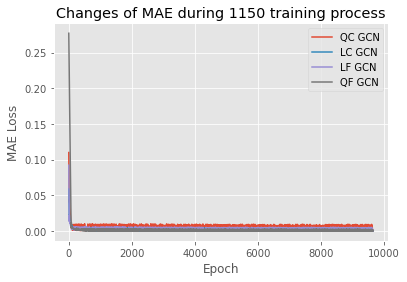

In [22]:
plt.style.use('ggplot')
QCGCN_Loss_list_numpy = []
LCGCN_Loss_list_numpy = []
LFGCN_Loss_list_numpy = []
QFGCN_Loss_list_numpy = []
for i in QCGCN_Loss_list:
    QCGCN_Loss_list_numpy.append(i.detach().numpy())
for i in LCGCN_Loss_list:
    LCGCN_Loss_list_numpy.append(i.detach().numpy())
for i in LFGCN_Loss_list:
    LFGCN_Loss_list_numpy.append(i.detach().numpy())
for i in QFGCN_Loss_list:
    QFGCN_Loss_list_numpy.append(i.detach().numpy())
    
plt.plot(QCGCN_Loss_list_numpy,label='QC GCN')
plt.plot(LCGCN_Loss_list_numpy,label='LC GCN')
plt.plot(LFGCN_Loss_list_numpy,label='LF GCN')
plt.plot(QFGCN_Loss_list_numpy,label='QF GCN')
plt.title('Changes of MAE during 1150 training process')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(loc=1)
plt.show()

In [23]:
QCGCN_During=np.sum(QCGCN_MAE_Dur_list)
LCGCN_During=np.sum(LCGCN_MAE_Dur_list)
LFGCN_During=np.sum(LFGCN_MAE_Dur_list)
QFGCN_During=np.sum(QFGCN_MAE_Dur_list)

In [24]:
QCGCN_During,LCGCN_During,LFGCN_During,QFGCN_During

(16.68915367126465, 17.06549382209778, 17.595953941345215, 18.811075448989868)

In [25]:
def mean_losslist(tlist):
    return np.sum(tlist)/len(tlist)

In [26]:
mean_losslist(QCGCN_Loss_list_numpy),mean_losslist(LCGCN_Loss_list_numpy),mean_losslist(LFGCN_Loss_list_numpy),mean_losslist(QFGCN_Loss_list_numpy)

(0.0021223924073530604,
 0.0011058869633649914,
 0.001450484873717313,
 0.0017595336597818166)

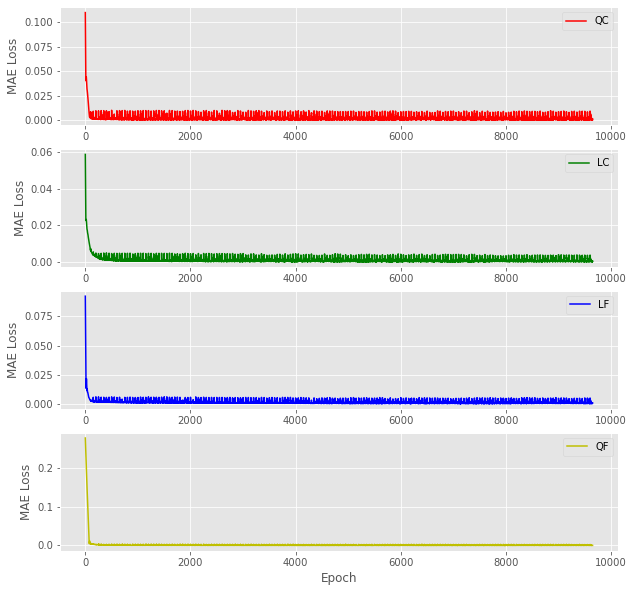

In [27]:
plt.figure(figsize=(10,10))
plt.figure(1)
ax1 = plt.subplot(411)
plt.plot(QCGCN_Loss_list_numpy,color='r',linestyle = "-",label='QC')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax2 = plt.subplot(412)
plt.plot(LCGCN_Loss_list_numpy,color='g',linestyle = "-",label='LC')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax3 = plt.subplot(413)
plt.plot(LFGCN_Loss_list_numpy,color='b',linestyle = "-",label='LF')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax4= plt.subplot(414)
plt.plot(QFGCN_Loss_list_numpy,color='y',linestyle = "-",label='QF')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
plt.xlabel('Epoch')
plt.show()

In [28]:
def gcn_valid(network,G,test_input,test_label,criterion,loss_list):
    for i in range(len(test_input)):
        loss = criterion(network(G,test_input[i]),test_label[i])
        loss_list.append(loss)

In [29]:
QCGCN_valid_loss_list=[];QCGCN_valid_loss_list.clear()
gcn_valid(QCGCN,GQC,valid_x,valid_y,nn.L1Loss(),QCGCN_valid_loss_list)

In [30]:
LCGCN_valid_loss_list=[];LCGCN_valid_loss_list.clear()
gcn_valid(LCGCN,GLC,valid_x,valid_y,nn.L1Loss(),LCGCN_valid_loss_list)

In [31]:
LFGCN_valid_loss_list=[];LFGCN_valid_loss_list.clear()
gcn_valid(LFGCN,GLF,valid_x,valid_y,nn.L1Loss(),LFGCN_valid_loss_list)

In [32]:
QFGCN_valid_loss_list=[];QFGCN_valid_loss_list.clear()
gcn_valid(QFGCN,GQF,valid_x,valid_y,nn.L1Loss(),QFGCN_valid_loss_list)

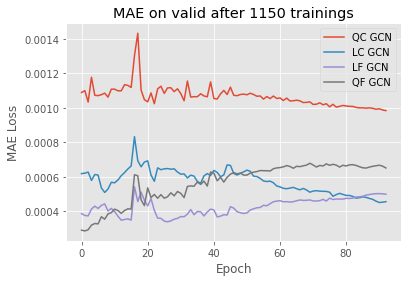

In [33]:
QCGCN_valid_loss_list_numpy = []
LCGCN_valid_loss_list_numpy = []
LFGCN_valid_loss_list_numpy = []
QFGCN_valid_loss_list_numpy = []
for i in QCGCN_valid_loss_list:
    QCGCN_valid_loss_list_numpy.append(i.detach().numpy())
for i in LCGCN_valid_loss_list:
    LCGCN_valid_loss_list_numpy.append(i.detach().numpy())
for i in LFGCN_valid_loss_list:
    LFGCN_valid_loss_list_numpy.append(i.detach().numpy())
for i in QFGCN_valid_loss_list:
    QFGCN_valid_loss_list_numpy.append(i.detach().numpy())

plt.plot(QCGCN_valid_loss_list_numpy,label='QC GCN')
plt.plot(LCGCN_valid_loss_list_numpy,label='LC GCN')
plt.plot(LFGCN_valid_loss_list_numpy,label='LF GCN')
plt.plot(QFGCN_valid_loss_list_numpy,label='QF GCN')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE on valid after 1150 trainings')
plt.legend(loc=1)

In [34]:
def gcn_tester(network,G,test_input,test_label,criterion,loss_list):
    for i in range(len(test_input)):
        loss = criterion(network(G,test_input[i]),test_label[i])
        loss_list.append(loss)

In [35]:
QCGCN_test_loss_list=[];QCGCN_test_loss_list.clear()
gcn_tester(QCGCN,GQC,test_x,test_y,nn.L1Loss(),QCGCN_test_loss_list)

In [36]:
LCGCN_test_loss_list=[];LCGCN_test_loss_list.clear()
gcn_tester(LCGCN,GLC,test_x,test_y,nn.L1Loss(),LCGCN_test_loss_list)

In [37]:
LFGCN_test_loss_list=[];LFGCN_test_loss_list.clear()
gcn_tester(LFGCN,GLF,test_x,test_y,nn.L1Loss(),LFGCN_test_loss_list)

In [38]:
QFGCN_test_loss_list=[];QFGCN_test_loss_list.clear()
gcn_tester(QFGCN,GQF,test_x,test_y,nn.L1Loss(),QFGCN_test_loss_list)

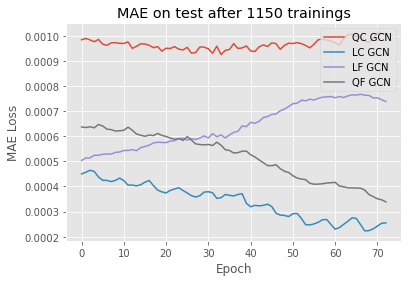

In [39]:
QCGCN_test_loss_list_numpy = []
LCGCN_test_loss_list_numpy = []
LFGCN_test_loss_list_numpy = []
QFGCN_test_loss_list_numpy = []

for i in QCGCN_test_loss_list:
    QCGCN_test_loss_list_numpy.append(i.detach().numpy())
    
for i in LCGCN_test_loss_list:
    LCGCN_test_loss_list_numpy.append(i.detach().numpy())
    
for i in LFGCN_test_loss_list:
    LFGCN_test_loss_list_numpy.append(i.detach().numpy())
    
for i in QFGCN_test_loss_list:
    QFGCN_test_loss_list_numpy.append(i.detach().numpy())

plt.plot(QCGCN_test_loss_list_numpy,label='QC GCN')
plt.plot(LCGCN_test_loss_list_numpy,label='LC GCN')
plt.plot(LFGCN_test_loss_list_numpy,label='LF GCN')
plt.plot(QFGCN_test_loss_list_numpy,label='QF GCN')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE on test after 1150 trainings')
plt.legend(loc=1)

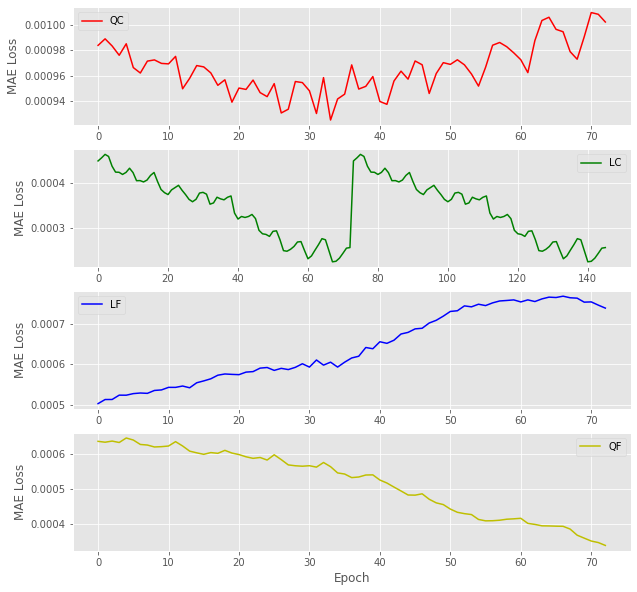

In [41]:
plt.figure(figsize=(10,10))
plt.figure(1)

QCGCN_test_loss_list_numpy = []
LCRGCN_test_loss_list_numpy = []
LFGCN_test_loss_list_numpy = []
QFGCN_test_loss_list_numpy = []

for i in QCGCN_test_loss_list:
    QCGCN_test_loss_list_numpy.append(i.detach().numpy())
for i in LCGCN_test_loss_list:
    LCGCN_test_loss_list_numpy.append(i.detach().numpy())
for i in LFGCN_test_loss_list:
    LFGCN_test_loss_list_numpy.append(i.detach().numpy())
for i in QFGCN_test_loss_list:
    QFGCN_test_loss_list_numpy.append(i.detach().numpy())

ax1 = plt.subplot(411)
plt.plot(QCGCN_test_loss_list_numpy,color="r",linestyle = "-",label='QC')
plt.ylabel('MAE Loss')
plt.legend()

ax2 = plt.subplot(412)
plt.plot(LCGCN_test_loss_list_numpy, color="g",linestyle = "-",label='LC')
plt.ylabel('MAE Loss')
plt.legend()

ax3 = plt.subplot(413)
plt.plot(LFGCN_test_loss_list_numpy,color="b",linestyle = "-",label='LF')
plt.ylabel('MAE Loss')
plt.legend()

ax4 = plt.subplot(414)
plt.plot(QFGCN_test_loss_list_numpy,color="y",linestyle = "-",label='QF')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()

In [42]:
mean_losslist(QCGCN_test_loss_list_numpy),mean_losslist(LCGCN_test_loss_list_numpy)

(0.0009656207610483038, 0.00033931043764499766)

In [43]:
mean_losslist(LFGCN_test_loss_list_numpy),mean_losslist(QFGCN_test_loss_list_numpy)

(0.0006427817454893295, 0.0005180957178546958)

## RNN

In [44]:
class RNNs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(RNNs,self).__init__()

        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.rnn(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [45]:
def rnn_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [46]:
RNN_Model = RNNs(7, 14, 1,2);RNN_Loss_list=[];RNN_Loss_list.clear();RNN_Dur_list=[]
rnn_trainer(RNN_Model,train_x,train_y,1150,th.optim.Adam(RNN_Model.parameters(), lr=1e-3),nn.L1Loss(),RNN_Loss_list,RNN_Dur_list)

Epoch 0100 | MAE_Loss 0.0083
Epoch 0200 | MAE_Loss 0.0045
Epoch 0300 | MAE_Loss 0.0075
Epoch 0400 | MAE_Loss 0.0050
Epoch 0500 | MAE_Loss 0.0042
Epoch 0600 | MAE_Loss 0.0030
Epoch 0700 | MAE_Loss 0.0037
Epoch 0800 | MAE_Loss 0.0013
Epoch 0900 | MAE_Loss 0.0021
Epoch 1000 | MAE_Loss 0.0018
Epoch 1100 | MAE_Loss 0.0036


No handles with labels found to put in legend.


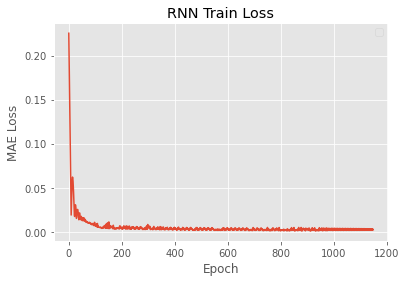

In [47]:
RNN_Loss_list_numpy =[]
for i in RNN_Loss_list:
    RNN_Loss_list_numpy.append(i.detach().numpy())
    
plt.style.use('ggplot')
plt.plot(RNN_Loss_list_numpy)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('RNN Train Loss')
plt.legend()

In [48]:
mean_losslist(RNN_Loss_list_numpy)

0.005378749681555706

In [49]:
def rnn_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [50]:
RNN_test_loss_list=[];RNN_test_loss_list.clear()
rnn_tester(RNN_Model,test_x,test_y,nn.L1Loss(),RNN_test_loss_list)

In [51]:
RNN_test_loss_list_numpy = []
for i in RNN_test_loss_list:
    RNN_test_loss_list_numpy.append(i.detach().numpy())
mean_losslist(RNN_test_loss_list_numpy)

0.003057378577068448

## LSTM

In [52]:
class LSTMs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(LSTMs,self).__init__()

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.lstm(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [53]:
LSTM_Model=LSTMs(7,14,1,2)

In [54]:
def lstm_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [55]:
LSTM_Loss_list=[];LSTM_Loss_list.clear();LSTM_Dur_list=[]
lstm_trainer(LSTM_Model,train_x,train_y,1150,th.optim.Adam(LSTM_Model.parameters(), lr=1e-3),nn.L1Loss(),LSTM_Loss_list,LSTM_Dur_list)

Epoch 0100 | MAE_Loss 0.0067
Epoch 0200 | MAE_Loss 0.0031
Epoch 0300 | MAE_Loss 0.0020
Epoch 0400 | MAE_Loss 0.0019
Epoch 0500 | MAE_Loss 0.0017
Epoch 0600 | MAE_Loss 0.0014
Epoch 0700 | MAE_Loss 0.0020
Epoch 0800 | MAE_Loss 0.0023
Epoch 0900 | MAE_Loss 0.0021
Epoch 1000 | MAE_Loss 0.0008
Epoch 1100 | MAE_Loss 0.0013


No handles with labels found to put in legend.


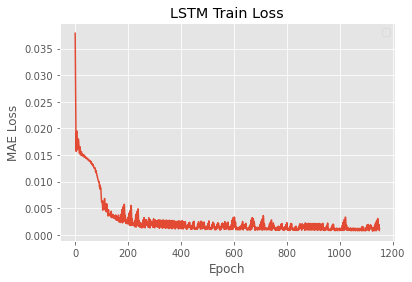

In [56]:
LSTM_Loss_list_numpy = []
for i in LSTM_Loss_list:
    LSTM_Loss_list_numpy.append(i.detach().numpy())

plt.style.use('ggplot')
plt.plot(LSTM_Loss_list_numpy)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('LSTM Train Loss')
plt.legend()

In [57]:
mean_losslist(LSTM_Loss_list_numpy)

0.0029094515676083774

In [58]:
def lstm_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [59]:
LSTM_test_loss_list=[];LSTM_test_loss_list.clear()
lstm_tester(LSTM_Model,test_x,test_y,nn.L1Loss(),LSTM_test_loss_list)

In [60]:
LSTM_test_loss_list_numpy = []
for i in LSTM_test_loss_list:
    LSTM_test_loss_list_numpy.append(i.detach().numpy())
mean_losslist(LSTM_test_loss_list_numpy)

0.0010546263074502349

## GRU

In [61]:
class GRUs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(GRUs,self).__init__()

        self.lstm = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.lstm(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [62]:
GRU_Model=GRUs(7,14,1,2)

In [63]:
def gru_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [64]:
GRU_Loss_list=[];GRU_Loss_list.clear();GRU_Dur_list=[]
gru_trainer(GRU_Model,train_x,train_y,1150,th.optim.Adam(GRU_Model.parameters(), lr=1e-3),nn.L1Loss(),GRU_Loss_list,GRU_Dur_list)

Epoch 0100 | MAE_Loss 0.0068
Epoch 0200 | MAE_Loss 0.0035
Epoch 0300 | MAE_Loss 0.0036
Epoch 0400 | MAE_Loss 0.0034
Epoch 0500 | MAE_Loss 0.0034
Epoch 0600 | MAE_Loss 0.0040
Epoch 0700 | MAE_Loss 0.0025
Epoch 0800 | MAE_Loss 0.0014
Epoch 0900 | MAE_Loss 0.0016
Epoch 1000 | MAE_Loss 0.0033
Epoch 1100 | MAE_Loss 0.0022


No handles with labels found to put in legend.


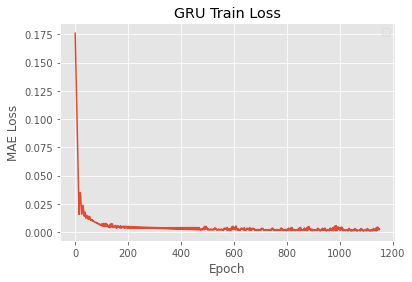

In [65]:
GRU_Loss_list_numpy = []
for i in GRU_Loss_list:
    GRU_Loss_list_numpy.append(i.detach().numpy())

plt.style.use('ggplot')
plt.plot(GRU_Loss_list_numpy)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('GRU Train Loss')
plt.legend()

In [66]:
mean_losslist(GRU_Loss_list_numpy)

0.005043563842773438

In [67]:
def gru_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [68]:
GRU_test_loss_list=[];GRU_test_loss_list.clear()
gru_tester(GRU_Model,test_x,test_y,nn.L1Loss(),GRU_test_loss_list)

In [69]:
GRU_test_loss_list_numpy = []
for i in GRU_test_loss_list:
    GRU_test_loss_list_numpy.append(i.detach().numpy())
    
mean_losslist(GRU_test_loss_list_numpy)

0.0014326284872367978

## 综合分析

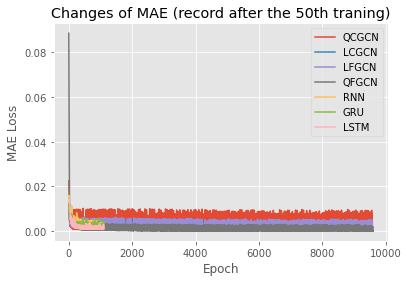

In [70]:
plt.style.use('ggplot')
plt.plot(QCGCN_Loss_list_numpy[50:],label='QCGCN')
plt.plot(LCGCN_Loss_list_numpy[50:],label='LCGCN')
plt.plot(LFGCN_Loss_list_numpy[50:],label='LFGCN')
plt.plot(QFGCN_Loss_list_numpy[50:],label='QFGCN')
plt.plot(RNN_Loss_list_numpy[50:],label='RNN')
plt.plot(GRU_Loss_list_numpy[50:],label='GRU')
plt.plot(LSTM_Loss_list_numpy[50:],label='LSTM')

plt.title('Changes of MAE (record after the 50th traning)')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(loc=1)
plt.show()

In [71]:
QCGCN_test_loss_list

[tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0009, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0009, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0009, grad_fn=<L1LossBackward>),
 tensor(0.0010, grad_fn=<L1LossBackward>),
 tensor(0.0

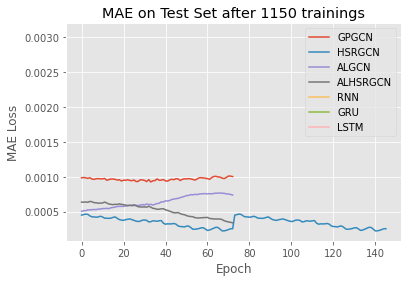

In [72]:
plt.plot(QCGCN_test_loss_list_numpy,label='GPGCN')
plt.plot(LCGCN_test_loss_list_numpy,label='HSRGCN')
plt.plot(LFGCN_test_loss_list_numpy,label='ALGCN')
plt.plot(QFGCN_test_loss_list_numpy,label='ALHSRGCN')
plt.plot(RNN_test_loss_list_numpy,label='RNN')
plt.plot(GRU_test_loss_list_numpy,label='GRU')
plt.plot(LSTM_test_loss_list_numpy,label='LSTM')

plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
#plt.ylim(0.000,0.4)
plt.title('MAE on Test Set after 1150 trainings')
plt.legend()

In [73]:
RNN_During,LSTM_During,GRU_During=np.sum(RNN_Dur_list),np.sum(LSTM_Dur_list),np.sum(GRU_Dur_list)
RNN_During,LSTM_During,GRU_During

(63.19436836242676, 215.74285674095154, 210.378986120224)

In [74]:
MAE_LIST=[mean_losslist(QCGCN_test_loss_list_numpy).item(),
 mean_losslist(LCGCN_test_loss_list_numpy).item(),
 mean_losslist(LFGCN_test_loss_list_numpy).item(),
 mean_losslist(QFGCN_test_loss_list_numpy).item(),
           mean_losslist(RNN_test_loss_list_numpy).item(),
          mean_losslist(GRU_test_loss_list_numpy).item(),
           mean_losslist(LSTM_test_loss_list_numpy).item()]
DUR_LIST=[QCGCN_During,LCGCN_During,LFGCN_During,QFGCN_During,RNN_During,GRU_During,LSTM_During]
NAME_LIST=['QC GCN','LC GCN',"LF GCN","QF GCN",'RNN','GRU','LSTM']

In [75]:
len(MAE_LIST),len(DUR_LIST),len(NAME_LIST)

(7, 7, 7)

In [76]:
MAEDUR_dict={'MAE':MAE_LIST,'DUR':DUR_LIST,'NAME':NAME_LIST}
MAEDUR=pd.DataFrame(MAEDUR_dict)
MAEDUR=MAEDUR.set_index(MAEDUR['NAME'])
MAEDUR

,MAE,DUR,NAME
NAME,,,
QC GCN,0.000966,16.689154,QC GCN
LC GCN,0.000339,17.065494,LC GCN
LF GCN,0.000643,17.595954,LF GCN
QF GCN,0.000518,18.811075,QF GCN
RNN,0.003057,63.194368,RNN
GRU,0.001433,210.378986,GRU
LSTM,0.001055,215.742857,LSTM


<ipython-input-101-52fd8891e030>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


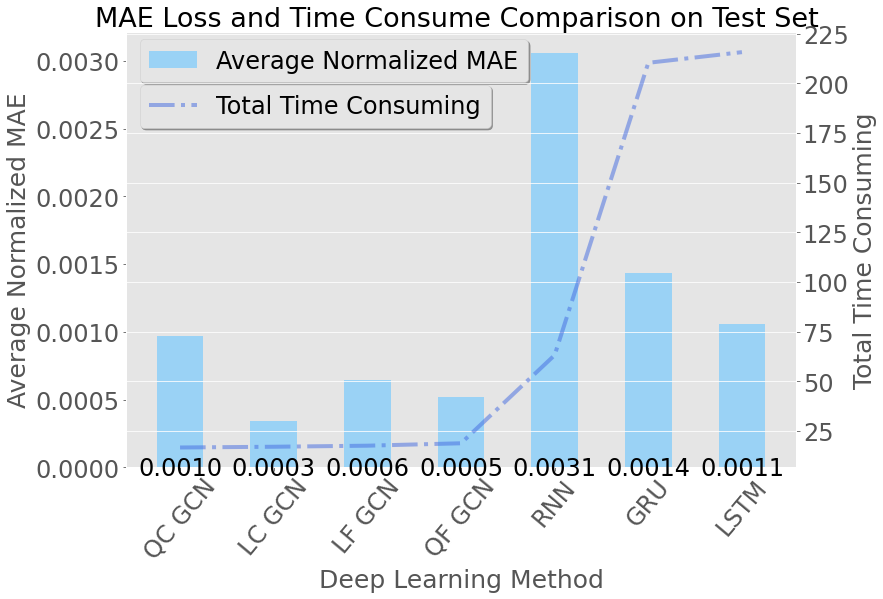

In [101]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
plt.xticks(rotation=50,fontsize=24)
plt.yticks(fontsize=24)
plt.grid(False) 
ax1=ax.twinx()

ax1.plot(MAEDUR['DUR'],color='#4169E1',linewidth=4,label='Total Time Consuming',alpha=0.5,linestyle = '-.')


ax.bar(MAEDUR['NAME'],MAEDUR['MAE'],width=0.5,label='Average Normalized MAE',color='#87CEFA',alpha=0.8)
#ax.legend(loc='best')

plt.yticks(fontsize=24)
ax.set_xlabel(r'Deep Learning Method',fontsize=25)
ax.set_ylabel(r'Average Normalized MAE',fontsize=25)     #plt.xticks(rotation=50,fontsize=13)



ax1.set_ylabel(r'Total Time Consuming',fontsize=25)
#plt.legend(loc=2,fontsize=14)


legend1=ax.legend(loc=(.02,.885),fontsize=24,shadow=True)
legend2=ax1.legend(loc=(.02,.78),fontsize=24,shadow=True)





for a,b in zip(MAEDUR.index,MAEDUR['MAE']):
    plt.text(a, b, '%.4f' % b, ha='center', va="bottom",fontsize=24)

'''
for a,b in zip(MAEDUR.index,MAEDUR['DUR']):
    plt.text(a, b+0.5, '%.2f' % b, ha='center', va="bottom",fontsize=16)
'''


plt.title('MAE Loss and Time Consume Comparison on Test Set ',fontsize=27) 

fig.show()